In [45]:
from Environment import Ecosystem
import plotly.graph_objects as go
import numpy as np
from Utils import hsv2rgb

In [46]:
default_params = {
    "mapsize": 400,
    "min_depth": 10,
    "max_depth": 70,
    "food_value": 30,
    "movement_cost": -1,
    "food_per_agent": 2,
    "max_timesteps": 200000,
    "movement_cost_factor": 0.04,
    "mutation_factor": 0.5,
    "starting_plant_population": 100,
    "plant_growth_speed": 0.01,
    "plant_minimum_growth_percentage": 0.5,
    "plant_spread_amount": 8,
    "plant_spread_radius": 800,
    "plant_spread_interval": 500,
    "max_plants_global": 100,
    "minimum_plant_percentage": 0.1,
}

default_species = {
    "hb1": {
        "name": "generic herbivore",
        "type": "herbivore",
        "population": 50,
        "spawn_count": 2,
        "color": 90,
        "rgb": hsv2rgb(90, 1, 1),
        "genome": {
            "speed": {"min": 1.0, "max": 6.0},
            "health": {"min": 130.0, "max": 200.0},
            "stomach_size": {"min": 20.0, "max": 40.0},
            "armor": {"min": 0.0, "max": 5.0},
            "bite_damage": {"min": 5.0, "max": 20.0},
            "eyesight_range": {"min": 10.0, "max": 30.0},
            "feed_range": {"min": 3.0, "max": 4.0},
            "bite_range": {"min": 2.0, "max": 3.0},
            "memory": {"min": 15, "max": 25},
            "depth_tolerance_range": {"min": 110, "max": 115},
            "lifespan": 500,
            "egg_lifespan_required": 0.1,
        }
    },
    "cv1": {
        "name": "generic carnivore",
        "type": "carnivore",
        "population": 80,
        "spawn_count": 1,
        "color": 0,
        "rgb": hsv2rgb(0, 1, 1),
        "genome": {
            "speed": {"min": 2.5, "max": 7.0},
            "health": {"min": 60.0, "max": 110.0},
            "stomach_size": {"min": 15.0, "max": 20.0},
            "armor": {"min": 2.0, "max": 7.0},
            "bite_damage": {"min": 20.0, "max": 40.0},
            "eyesight_range": {"min": 15.0, "max": 40.0},
            "feed_range": {"min": 2.0, "max": 3.0},
            "bite_range": {"min": 2.0, "max": 4.0},
            "memory": {"min": 10, "max": 20},
            "depth_tolerance_range": {"min": 115, "max": 135},
            "lifespan": 1000,
            "egg_lifespan_required": 0.15,
        }
    },
    "n_p": {
        "name": "Nile Perch",
        "type": "carnivore",
        "population": 13,
        "spawn_count": 1,
        "color": 150,
        "rgb": hsv2rgb(150, 1, 1),
        "genome": {
            "speed": {"min": 3.0, "max": 10.0},
            "health": {"min": 580.0, "max": 1150.0},
            "stomach_size": {"min": 80.0, "max": 120.0},
            "armor": {"min": 5.0, "max": 20.0},
            "bite_damage": {"min": 40.0, "max": 70.0},
            "eyesight_range": {"min": 30.0, "max": 70.0},
            "feed_range": {"min": 1.0, "max": 2.0},
            "bite_range": {"min": 3.0, "max": 5.0},
            "memory": {"min": 20, "max": 50},
            "depth_tolerance_range": {"min": 100, "max": 150},
            "lifespan": 2000,
            "egg_lifespan_required": 0.2,
        }
    },
}

In [47]:
env = Ecosystem("human", params=default_params, species=default_species, debug=False)
env.reset()
try:
    while not env.finished:
        env.stepper()
except KeyboardInterrupt:
    env.close()

[[29 29 29 ... 27 27 27]
 [29 29 29 ... 27 27 27]
 [29 29 29 ... 27 27 27]
 ...
 [24 24 24 ... 10 10 10]
 [24 24 24 ... 10 10 10]
 [24 24 24 ... 10 10 10]]
Closing environment Ecosystem at 745 timestep.


In [48]:
import json
import os

def load_histories(run_folder=None):
    """
    Load agent and plant histories from the most recent or specified run folder.

    Args:
        run_folder (str): Path to the folder containing history files.
                          If None, it finds the most recent run folder.

    Returns:
        Tuple:
            - agent_history (list): Combined history of all agents.
            - plant_history (list): Combined history of all plants.
    """
    base_dir = "history_logs"
    if run_folder is None:
        # Find the most recent folder
        run_folders = [f for f in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, f))]
        if not run_folders:
            raise ValueError("No run folders found in history_logs.")
        run_folder = max(run_folders, key=lambda f: os.path.getmtime(os.path.join(base_dir, f)))

    run_path = os.path.join(base_dir, run_folder)

    # Load and combine agent histories
    agent_files = sorted(
        [f for f in os.listdir(run_path) if f.startswith("agenthistory") and f.endswith(".json")],
        key=lambda f: int(f.replace("agenthistory", "").replace(".json", ""))
    )
    agent_history = []
    for file in agent_files:
        with open(os.path.join(run_path, file), 'r') as f:
            agent_history.extend(json.load(f))

    # Load and combine plant histories
    plant_files = sorted(
        [f for f in os.listdir(run_path) if f.startswith("planthistory") and f.endswith(".json")],
        key=lambda f: int(f.replace("planthistory", "").replace(".json", ""))
    )
    plant_history = []
    for file in plant_files:
        with open(os.path.join(run_path, file), 'r') as f:
            plant_history.extend(json.load(f))

    return agent_history, plant_history



In [49]:
def analyze_agent_lifecycle(env):
    """
    Lists each agent and analyzes:
      - Final cause of death (if any)
      - Breeding conditions at the end of life (or end of simulation)
    
    Returns:
      A list of dictionaries, one per agent, with keys:
        {
          "agent_name": str,
          "death_cause": str,
          "death_timestep": int or None,
          "final_timestep": int,
          "final_health": float,
          "final_food": float,
          "breeding_eligible": bool
        }
    """
    results = []
    
    # Build a set of all agents that ever existed
    # (some may still be alive, some may be in death_log).
    all_agents_ever = set(env.death_log.keys()) | set(env.agentNames)
    
    # For each agent, find the last timestep it appeared in agent_history
    for agent_name in sorted(all_agents_ever):
        final_timestep = None
        final_agent_data = None
        
        # Walk backwards through agent_history until we find the agent
        for t in reversed(range(len(env.agent_history))):
            if agent_name in env.agent_history[t]:
                final_timestep = t
                final_agent_data = env.agent_history[t][agent_name]
                break
        
        if final_timestep is None:
            # Possibly this agent never even made it into agent_history?
            # e.g., if it died upon creation. We'll skip or mark unknown
            reason = ""
            if agent_name in set(env.death_log.keys()):
                reason = env.death_log[agent_name]["reason"]

            results.append({
                "agent_name": agent_name,
                "death_cause": f"never appeared {agent_name in set(env.death_log.keys())} . {agent_name in set(env.agentNames)} . {reason}",
                "death_timestep": None,
                "final_timestep": None,
                "final_health": None,
                "final_food": None,
                "breeding_eligible": False
            })
            continue
        
        # Get cause/time of death if present
        death_info = env.death_log.get(agent_name, None)
        if death_info:
            death_cause = death_info["reason"]
            death_time = death_info["time"]
        else:
            death_cause = "alive"
            death_time = None
            
        final_health = final_agent_data.health
        final_food = final_agent_data.food
        
        egg_ok = (final_agent_data.egg_permitted >= final_agent_data.lifespan * 0.3)
        food_ok = (final_food >= final_agent_data.stomach_size / 2)
        breeding_eligible = (egg_ok and food_ok)
        
        results.append({
            "agent_name": agent_name,
            "death_cause": death_cause,
            "depth": final_agent_data.depth,
            "depth_min": final_agent_data.stats["depth_point"] - final_agent_data.stats["depth_tolerance_range"],
            "depth_max": final_agent_data.stats["depth_point"] + final_agent_data.stats["depth_tolerance_range"],
            "death_timestep": death_time,
            "final_timestep": final_timestep,
            "final_health": final_health,
            "final_food": final_food,
            "breeding_eligible": breeding_eligible,
            "egg_ok": [egg_ok, final_agent_data.egg_permitted, final_agent_data.lifespan * 0.3],
            "food_ok": food_ok,
        })
    
    return results


In [50]:
report = analyze_agent_lifecycle(env)
for row in report:
    if row["death_cause"] != "starved":
        for key, value in row.items():
            print(key, value)
        print('\n')


agent_name hb1-100-0
death_cause never appeared True . False . starved
death_timestep None
final_timestep None
final_health None
final_food None
breeding_eligible False


agent_name hb1-1004-0
death_cause alive
depth 15.796435835618501
depth_min -82.73645403931377
depth_max 140.38169500021078
death_timestep None
final_timestep 144
final_health 211.14525375314025
final_food 4.140389212988887
breeding_eligible False
egg_ok [False, 118, 167.08779721811342]
food_ok False


agent_name hb1-101-0
death_cause never appeared True . False . starved
death_timestep None
final_timestep None
final_health None
final_food None
breeding_eligible False


agent_name hb1-1010-0
death_cause alive
depth 20.92445946701586
depth_min -70.80394802500675
depth_max 156.13036691998076
death_timestep None
final_timestep 144
final_health 178.3310089260726
final_food 5.530241252272953
breeding_eligible False
egg_ok [False, 120, 172.64427821739545]
food_ok False


agent_name hb1-1011-0
death_cause alive
depth 22.99401

In [51]:
import plotly.graph_objects as go

def agent_stat_value(agent_dict, stat_key):
    """
    Safely returns a numeric value for the specified stat_key in a *dictionary-based* agent.

    agent_dict example:
      {
        'name': 'hb1_agent_0',
        'stats': { 'species': 'hb1', 'speed': 5.03, ... },
        'health': 99.8,
        'lifespan': 1022.53,
        'egg_permitted': 110,
        ...
      }

    Special handling:
      - "movement_cost" => negate it (as in original code)
      - "life_percentage" => compute (egg_permitted / lifespan)
      - else => first check agent_dict, then agent_dict['stats']
    """
    if stat_key == "movement_cost":
        base_val = agent_dict.get("movement_cost", agent_dict["stats"].get("movement_cost", 0.0))
        return -base_val

    if stat_key == "life_percentage":
        lifespan = agent_dict.get("lifespan", 1.0)  # avoid divide by zero
        age = agent_dict.get("egg_permitted", 0.0)
        return age / lifespan

    # General fallback: check top-level, then stats sub-dict
    if stat_key in agent_dict:
        return agent_dict[stat_key]
    return agent_dict["stats"].get(stat_key, 0.0)


def rolling_average(series, window=1):
    """
    Computes a simple rolling average of 'series' using the specified 'window' size.
    If window <= 1, returns the original series (no smoothing).
    """
    if window <= 1:
        return series

    smoothed = []
    for i in range(len(series)):
        start_idx = max(0, i - window + 1)
        subset = series[start_idx : i + 1]
        smoothed.append(sum(subset) / len(subset))
    return smoothed


def identify_all_species(agent_history):
    """
    Scans agent_history to collect a sorted list of all species present.
    agent_history is a list of dicts (one per timestep), where each dict is
    {agent_name: agent_dict, ...}.

    Returns a sorted list of unique species strings.
    """
    species_set = set()
    for timestep_dict in agent_history:
        for _, agent_data in timestep_dict.items():
            sp = agent_data["stats"].get("species", "unknown")
            species_set.add(sp)
    return sorted(list(species_set))


def plot_parameter_over_time(
    agent_history,
    plant_history,
    parameter="population",
    mode="species",
    use_log_scale=False,
    smoothing_window=1,
    use_percentage=False,
    plant_scale_divisor=1.0,
    species_info=None
):
    """
    Plots a chosen parameter (or multiple) from agent_history & plant_history over time using Plotly,
    all on a SINGLE plot.

    Arguments:
        agent_history: list of dicts, one per timestep. Each dict: { agent_name: agent_data, ... }
        plant_history: list of lists, one per timestep. Each list is the set (or list) of plant data.
        parameter (str):
            - "population" => plots agent population + scaled plant pop
            - "all" => plots multiple numeric agent stats in one figure
            - or a single numeric stat name (including "life_percentage").
        mode (str): "species" => separate lines per species, "total" => single line across all
        use_log_scale (bool): if True & parameter=="population", we apply log scale on the Y-axis
        smoothing_window (int): rolling average window
        use_percentage (bool): if True, lines show % change from first smoothed value
                               else show raw/smoothed absolute values
        plant_scale_divisor (float): scale factor for plant population in the plot
        species_info (dict or None): optional mapping {species_name: {"name":..., "rgb":(r,g,b)} }
                                     for coloring or labeling. If None, we use a simple palette.

    Returns:
        plotly.graph_objects.Figure
    """
    import numpy as np

    # Basic check
    num_timesteps = len(agent_history)
    if num_timesteps == 0:
        raise ValueError("Empty agent_history: no data to plot.")

    # x-axis time dimension
    timesteps = list(range(num_timesteps))

    # Helper: convert raw values -> % from first
    def pct_change_from_first(values):
        if not values:
            return []
        first_val = values[0]
        if first_val == 0:
            return [0] * len(values)
        return [((v - first_val) / first_val) * 100 for v in values]

    # Identify all species from agent_history
    all_species = identify_all_species(agent_history)

    # If user provided a species_info dict with colors, use that; else fallback palette
    fallback_palette = [
        "rgb(255,0,0)",   "rgb(0,255,0)",   "rgb(0,0,255)",
        "rgb(255,165,0)", "rgb(255,0,255)", "rgb(128,0,128)",
        "rgb(0,128,128)", "rgb(128,128,0)", "rgb(70,70,70)",
        "rgb(0,0,0)",     "rgb(60,180,75)", "rgb(230,25,75)"
    ]
    species_color_map = {}
    for idx, sp in enumerate(all_species):
        if species_info and sp in species_info and "rgb" in species_info[sp]:
            rgb = species_info[sp]["rgb"]  # assumed to be (r,g,b)
            species_color_map[sp] = f"rgb({rgb[0]},{rgb[1]},{rgb[2]})"
        else:
            color_ = fallback_palette[idx % len(fallback_palette)]
            species_color_map[sp] = color_

    # --------------------------
    # Case: parameter == "all"
    # --------------------------
    if parameter == "all":
        # The numeric stats you want to display side-by-side
        numeric_stats = [
            "speed", "armor", "memory", "movement_cost", "health", "stomach_size",
            "bite_damage", "eyesight_range", "feed_range", "bite_range", "life_percentage"
        ]

        fig = go.Figure()

        if mode == "species":
            # We'll make lines for each (species, attribute) combination
            dash_styles = ["solid", "dot", "dash", "longdash", "dashdot", "longdashdot"]

            for sp in all_species:
                dash_index = 0
                for attr in numeric_stats:
                    raw_values = []
                    for t in range(num_timesteps):
                        timestep_data = agent_history[t]
                        sum_attr, count_attr = 0.0, 0
                        for agent_dict in timestep_data.values():
                            if agent_dict["stats"].get("species", "unknown") == sp:
                                sum_attr += agent_stat_value(agent_dict, attr)
                                count_attr += 1
                        avg_attr = (sum_attr / count_attr) if count_attr else 0
                        raw_values.append(avg_attr)

                    smoothed = rolling_average(raw_values, smoothing_window)
                    data_plot = pct_change_from_first(smoothed) if use_percentage else smoothed

                    fig.add_trace(
                        go.Scatter(
                            x=timesteps,
                            y=data_plot,
                            mode='lines',
                            line=dict(
                                color=species_color_map[sp],
                                dash=dash_styles[dash_index % len(dash_styles)]
                            ),
                            name=f"{sp}-{attr}"
                        )
                    )
                    dash_index += 1

            title_str = "All Attributes"
            if use_percentage:
                title_str += " (% Change)"
            else:
                title_str += " (Absolute)"

            fig.update_layout(
                title=f"{title_str} Over Time (mode={mode})",
                xaxis_title="Timestep",
                yaxis_title="Value" if not use_percentage else "% Change from T=0"
            )
            if use_log_scale:
                fig.update_yaxes(type="log")
            return fig

        else:
            # mode = "total": sum or average across ALL agents for each attr
            color_palette = fallback_palette  # reuse
            fig = go.Figure()
            for i, attr in enumerate(numeric_stats):
                raw_values = []
                for t in range(num_timesteps):
                    timestep_data = agent_history[t]
                    sum_val, count_val = 0.0, 0
                    for agent_dict in timestep_data.values():
                        sum_val += agent_stat_value(agent_dict, attr)
                        count_val += 1
                    avg_val = sum_val / count_val if count_val else 0
                    raw_values.append(avg_val)

                smoothed = rolling_average(raw_values, smoothing_window)
                data_plot = pct_change_from_first(smoothed) if use_percentage else smoothed
                color_ = color_palette[i % len(color_palette)]

                fig.add_trace(
                    go.Scatter(
                        x=timesteps,
                        y=data_plot,
                        mode='lines',
                        line=dict(color=color_),
                        name=f"All-{attr}"
                    )
                )

            title_str = "All Attributes"
            if use_percentage:
                title_str += " (% Change)"
            else:
                title_str += " (Absolute)"
            fig.update_layout(
                title=f"{title_str} Over Time (mode={mode})",
                xaxis_title="Timestep",
                yaxis_title="Value" if not use_percentage else "% Change from T=0"
            )
            if use_log_scale:
                fig.update_yaxes(type="log")
            return fig

    # --------------------------
    # Case: parameter == "population"
    # --------------------------
    if parameter == "population":
        fig = go.Figure()

        # Gather plant counts
        plant_counts = []
        if plant_history:
            # Each entry is a list of plants at that timestep
            for t in range(num_timesteps):
                plant_counts.append(len(plant_history[t]))
        else:
            plant_counts = [0] * num_timesteps

        # scale them
        if plant_scale_divisor != 1.0:
            plant_counts = [pc / plant_scale_divisor for pc in plant_counts]

        if mode == "species":
            # separate line for each species
            for sp in all_species:
                raw_vals = []
                for t in range(num_timesteps):
                    timestep_data = agent_history[t]
                    # Count how many agents of species 'sp' are alive
                    c_sp = sum(
                        1 for agent_dict in timestep_data.values()
                        if agent_dict["stats"].get("species","unknown") == sp
                    )
                    raw_vals.append(c_sp)

                smoothed = rolling_average(raw_vals, smoothing_window)
                data_plot = pct_change_from_first(smoothed) if use_percentage else smoothed

                fig.add_trace(
                    go.Scatter(
                        x=timesteps,
                        y=data_plot,
                        mode='lines',
                        line=dict(color=species_color_map[sp]),
                        name=f"{sp} population"
                    )
                )

            # Add plants
            smoothed_plants = rolling_average(plant_counts, smoothing_window)
            plant_plot = pct_change_from_first(smoothed_plants) if use_percentage else smoothed_plants
            fig.add_trace(
                go.Scatter(
                    x=timesteps,
                    y=plant_plot,
                    mode='lines',
                    line=dict(color="rgb(0,128,0)"),
                    name=f"Plants (/ {plant_scale_divisor})"
                )
            )

        else:
            # mode="total"
            agent_raw = []
            for t in range(num_timesteps):
                timestep_data = agent_history[t]
                agent_raw.append(len(timestep_data))

            smoothed_agents = rolling_average(agent_raw, smoothing_window)
            agent_plot = pct_change_from_first(smoothed_agents) if use_percentage else smoothed_agents
            fig.add_trace(
                go.Scatter(
                    x=timesteps,
                    y=agent_plot,
                    mode='lines',
                    line=dict(color="rgb(0,0,0)"),
                    name="All Agents population"
                )
            )

            smoothed_plants = rolling_average(plant_counts, smoothing_window)
            plant_plot = pct_change_from_first(smoothed_plants) if use_percentage else smoothed_plants
            fig.add_trace(
                go.Scatter(
                    x=timesteps,
                    y=plant_plot,
                    mode='lines',
                    line=dict(color="rgb(0,128,0)"),
                    name=f"Plants (/ {plant_scale_divisor})"
                )
            )

        pop_title = "Population"
        if use_percentage:
            pop_title += " (% Change)"
        else:
            pop_title += " (Absolute)"

        fig.update_layout(
            title=f"{pop_title} Over Time",
            xaxis_title="Timestep",
            yaxis_title="Count" if not use_percentage else "% Change from T=0"
        )
        if use_log_scale:
            fig.update_yaxes(type="log")
        return fig

    # -------------------------------------------------
    # Otherwise: a single numeric stat (e.g. "speed",
    # "health", "life_percentage", etc.)
    # -------------------------------------------------
    fig = go.Figure()

    if mode == "species":
        for sp in all_species:
            raw_vals = []
            for t in range(num_timesteps):
                timestep_data = agent_history[t]
                sum_val, count_val = 0.0, 0
                for agent_dict in timestep_data.values():
                    if agent_dict["stats"].get("species", "unknown") == sp:
                        sum_val += agent_stat_value(agent_dict, parameter)
                        count_val += 1
                avg_ = sum_val / count_val if count_val else 0
                raw_vals.append(avg_)

            smoothed = rolling_average(raw_vals, smoothing_window)
            data_plot = pct_change_from_first(smoothed) if use_percentage else smoothed

            fig.add_trace(
                go.Scatter(
                    x=timesteps,
                    y=data_plot,
                    mode='lines',
                    line=dict(color=species_color_map[sp]),
                    name=f"{sp} ({parameter})"
                )
            )
    else:
        # mode="total": single line across all agents
        raw_vals = []
        for t in range(num_timesteps):
            timestep_data = agent_history[t]
            s_, c_ = 0.0, 0
            for agent_dict in timestep_data.values():
                s_ += agent_stat_value(agent_dict, parameter)
                c_ += 1
            avg_ = s_ / c_ if c_ else 0
            raw_vals.append(avg_)

        smoothed = rolling_average(raw_vals, smoothing_window)
        data_plot = pct_change_from_first(smoothed) if use_percentage else smoothed

        fig.add_trace(
            go.Scatter(
                x=timesteps,
                y=data_plot,
                mode='lines',
                line=dict(color="rgb(0,0,0)"),
                name=f"All Agents ({parameter})"
            )
        )

    # Final labeling
    if use_percentage:
        title_str = f"{parameter.capitalize()} % Change Over Time"
        y_label_str = "% Change from T=0"
    else:
        title_str = f"{parameter.capitalize()} (Absolute) Over Time"
        y_label_str = f"{parameter.capitalize()}"

    fig.update_layout(
        title=title_str,
        xaxis_title="Timestep",
        yaxis_title=y_label_str
    )
    if use_log_scale:
        fig.update_yaxes(type="log")
    return fig


In [52]:
agent_history, plant_history = load_histories()

In [53]:
# Once the simulation completes, call the plotting function:
fig = plot_parameter_over_time(agent_history=agent_history, plant_history=plant_history, species_info=default_species, parameter="population", mode="species", use_log_scale=False, smoothing_window=5, plant_scale_divisor=3)
fig.show()  # or pio.show(fig)

fig2 = plot_parameter_over_time(agent_history=agent_history, plant_history=plant_history, species_info=default_species, parameter="movement_cost", mode="species", smoothing_window=5)
fig2.show()

fig3 = plot_parameter_over_time(agent_history=agent_history, plant_history=plant_history, species_info=default_species, parameter="all", mode="total", smoothing_window=5, use_percentage=True, use_log_scale=False)
fig3.show()

C:\Users\creep\AppData\Local\Temp\ipykernel_24720\3857098510.py:68: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown

C:\Users\creep\AppData\Local\Temp\ipykernel_24720\3857098510.py:71: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown

C:\Users\creep\AppData\Local\Temp\ipykernel_24720\3857098510.py:74: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown



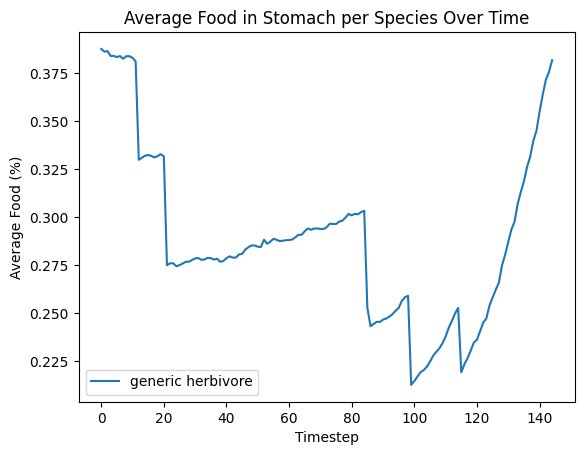

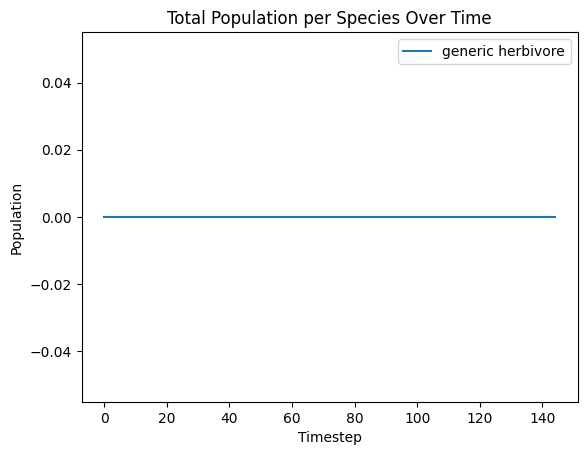

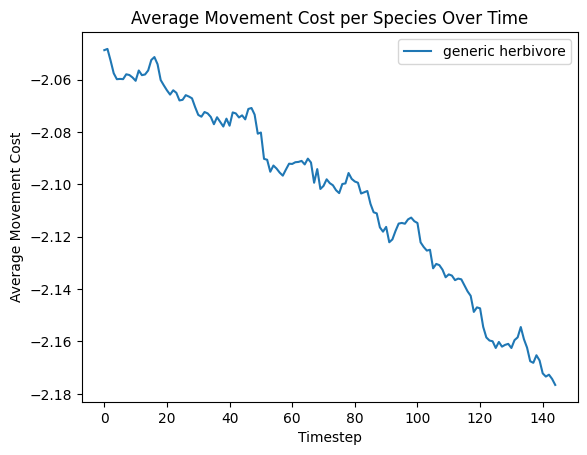

In [54]:
import matplotlib.pyplot as plt

def analyze_environment(env, parameter):
    """
    Analyzes the environment and creates a line graph based on the specified parameter.

    Args:
        env: The environment object.
        parameter: The parameter to analyze ("average_food", "population_total", "movement_cost").

    Returns:
        A matplotlib figure object.
    """

    if parameter not in ["average_food", "population_total", "movement_cost"]:
        raise ValueError("Invalid parameter. Choose from: 'average_food', 'population_total', 'movement_cost'")

    # Initialize data structures
    timesteps = range(len(env.agent_history))
    species_data = {species: [] for species in env.species.keys()}

    # Calculate average data for each species at each timestep
    for timestep, agents_at_timestep in enumerate(env.agent_history):
        species_counts = {s: 0 for s in env.species.keys()}
        species_averages = {s: 0 for s in env.species.keys()}  # Store averages for each species

        for agent_name, agent in agents_at_timestep.items():
            species = agent.stats["species"]
            species_counts[species] += 1

            if parameter == "average_food":
                species_averages[species] += agent.food / agent.stomach_size
            elif parameter == "movement_cost":
                species_averages[species] += agent.movement_cost

        # Calculate averages for each species at this timestep
        for species, count in species_counts.items():
            if count > 0:
                if parameter == "average_food":
                    species_averages[species] /= count 
                elif parameter == "movement_cost":
                    species_averages[species] /= count

            species_data[species].append(species_averages[species])

    # Create the plot
    fig, ax = plt.subplots()
    for species, data in species_data.items():
        ax.plot(timesteps, data, label=env.species[species]["name"])

    # Set plot labels and title
    if parameter == "average_food":
        ax.set_ylabel("Average Food (%)")
        ax.set_title("Average Food in Stomach per Species Over Time")
    elif parameter == "population_total":
        ax.set_ylabel("Population")
        ax.set_title("Total Population per Species Over Time")
    elif parameter == "movement_cost":
        ax.set_ylabel("Average Movement Cost")
        ax.set_title("Average Movement Cost per Species Over Time")

    ax.set_xlabel("Timestep")
    ax.legend()
    return fig

# Example usage:
fig_food = analyze_environment(env, "average_food")
fig_food.show() 

fig_population = analyze_environment(env, "population_total")
fig_population.show()

fig_cost = analyze_environment(env, "movement_cost")
fig_cost.show()

In [55]:
x = env.close()

Closing environment Ecosystem at 745 timestep.
